In [62]:
import abc
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

class ContinuousDistribution(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def import_data(self, file_path):
        pass

    @abc.abstractmethod
    def export_data(self, data, file_path):
        pass

    @abc.abstractmethod
    def compute_mean(self, data):
        pass

    @abc.abstractmethod
    def compute_standard_deviation(self, data):
        pass

    @abc.abstractmethod
    def visualize(self, data=None):
        pass

    @abc.abstractmethod
    def generate_samples(self, n_samples):
        pass



class GaussDistribution(ContinuousDistribution):

    def __init__(self, mu=None, cov=None, dim=None):
        super().__init__()
        self.mu = mu
        self.cov = cov
        self.dim = dim
        self.samples = None
        self.data = None

    def import_data(self, file_path):
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            next(reader)
            self.data = np.array([list(map(float, row)) for row in reader])

    def export_data(self, data, file_path):
        with open(file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(data)

    def compute_mean(self, data):
        self.mean = np.mean(data, axis=0)

    def compute_standard_deviation(self, data):
        self.cov = np.cov(data, rowvar=False)

    def visualize(self, data=None):
        if self.dim == 1:
            if data is not None:
                plt.hist(data, bins=30, density=True)
            else:
                x = np.linspace(self.mean - 3*np.sqrt(self.cov), self.mean + 3*np.sqrt(self.cov), 100)
                y = multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)
                plt.plot(x, y)
        elif self.dim == 2:
            if data is not None:
                plt.scatter(data[:,0], data[:,1], s=5)
            else:
                x, y = np.mgrid[self.mean[0]-3*np.sqrt(self.cov[0][0]):self.mean[0]+3*np.sqrt(self.cov[0][0]):.1,
                                self.mean[1]-3*np.sqrt(self.cov[1][1]):self.mean[1]+3*np.sqrt(self.cov[1][1]):.1]
                pos = np.empty(x.shape + (2,))
                pos[:, :, 0] = x; pos[:, :, 1] = y
                z = multivariate_normal.pdf(pos, mean=self.mean, cov=self.cov)
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                ax.plot_surface(x, y, z, cmap='viridis', linewidth=0)
        elif self.dim == 3:
            if data is not None:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(data[:,0], data[:,1], data[:,2], s=5)
            else:
                x, y, z = np.mgrid[self.mean[0]-3*np.sqrt(self.cov[0][0]):self.mean[0]+3*np.sqrt(self.cov[0][0]):.1,
                                    self.mean[1]-3*np.sqrt(self.cov[1][1]):self.mean[1]+3*np.sqrt(self.cov[1][1]):.1,
                                    self.mean[2]-3*np.sqrt(self.cov[2][2]):self.mean[2]+3*np.sqrt(self.cov[2][2]):.1]
                pos = np.empty(x.shape + (3,))
                pos[:, :, :, 0] = x; pos[:, :, :, 1] = y; pos[:, :, :, 2] = z
                w = multivariate_normal.pdf(pos, mean=self.mean, cov=self.cov)
                fig = plt.figure

    def generate_samples(self, num_samples):
        self.samples = np.random.multivariate_normal(mean=self.mean, cov=self.cov, size=num_samples)
        return np.random.multivariate_normal(self.mu, self.cov, num_samples)
    
    def pdf(self, x):
        """Evaluate the multivariate Gaussian PDF at the given points."""
        assert x.ndim == 2 and x.shape[1] == self.dim, f"Invalid shape of input array x: {x.shape}."
        norm_const = 1 / np.sqrt(((2 * np.pi) ** self.dim) * np.linalg.det(self.cov))
        x_centered = x - self.mu
        exp_term = np.exp(-0.5 * np.sum(np.dot(x_centered, np.linalg.inv(self.cov)) * x_centered, axis=1))
        return norm_const * exp_term

    def fit(self):
        self.compute_mean(self.data)
        self.compute_standard_deviation(self.data)
        self.mu = np.mean(self.data, axis=0)
        self.cov = np.cov(self.data.T)
        self.dim = self.data.shape[1]

    def fit_from_file(self, file_path):
        self.import_data(file_path)
        self.fit(self.data)

    def plot_samples_and_distribution(self):
        # Load the data from the file
        #data = np.loadtxt(file_path, delimiter=',', skiprows=1)
        
        # Generate samples from the distribution
        samples = self.generate_samples(num_samples=len(self.data))
        
        # Create a figure with two subfigures
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        
        # Plot the samples from the file
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', alpha=0.5)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Data from File')
        
        # Create a meshgrid for the domain of the distribution
        n_points = 100
        x = np.linspace(-10, 10, n_points)
        print(x)
        y = np.linspace(-10, 10, n_points)
        X, Y = np.meshgrid(x, y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        
        # Evaluate the distribution at the meshgrid points
        z = self.pdf(pos.reshape(-1, 2)).reshape(X.shape)
        
        # Plot the distribution and the samples
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.plot_surface(X, Y, z, cmap='viridis', linewidth=0, alpha=0.5)
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='red', alpha=0.5)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Multivariate Gaussian Distribution and Sampled Data')
        
        # Show the plot
        plt.show()

In [63]:
# Create a GaussDistribution object and fit it to the data
gd = GaussDistribution()
# Load the data from the csv file
#gd.data = np.loadtxt('MGD.csv', delimiter=',', skiprows=1)
gd.import_data('MGD.csv')
gd.dim=len(gd.data[1])
gd.fit()
print(gd.mu)
print(gd.cov)
print(gd.dim)

[0.98402576 0.00883296 0.8601148 ]
[[0.95707677 0.65248406 0.5632227 ]
 [0.65248406 1.42016015 0.75382979]
 [0.5632227  0.75382979 1.25559884]]
3


In [64]:
#Generate samples from the learned distribution
gd.generate_samples(num_samples=len(data))
print(len(gd.samples))

100


[-10.          -9.7979798   -9.5959596   -9.39393939  -9.19191919
  -8.98989899  -8.78787879  -8.58585859  -8.38383838  -8.18181818
  -7.97979798  -7.77777778  -7.57575758  -7.37373737  -7.17171717
  -6.96969697  -6.76767677  -6.56565657  -6.36363636  -6.16161616
  -5.95959596  -5.75757576  -5.55555556  -5.35353535  -5.15151515
  -4.94949495  -4.74747475  -4.54545455  -4.34343434  -4.14141414
  -3.93939394  -3.73737374  -3.53535354  -3.33333333  -3.13131313
  -2.92929293  -2.72727273  -2.52525253  -2.32323232  -2.12121212
  -1.91919192  -1.71717172  -1.51515152  -1.31313131  -1.11111111
  -0.90909091  -0.70707071  -0.50505051  -0.3030303   -0.1010101
   0.1010101    0.3030303    0.50505051   0.70707071   0.90909091
   1.11111111   1.31313131   1.51515152   1.71717172   1.91919192
   2.12121212   2.32323232   2.52525253   2.72727273   2.92929293
   3.13131313   3.33333333   3.53535354   3.73737374   3.93939394
   4.14141414   4.34343434   4.54545455   4.74747475   4.94949495
   5.151515

AssertionError: Invalid shape of input array x: (10000, 2).

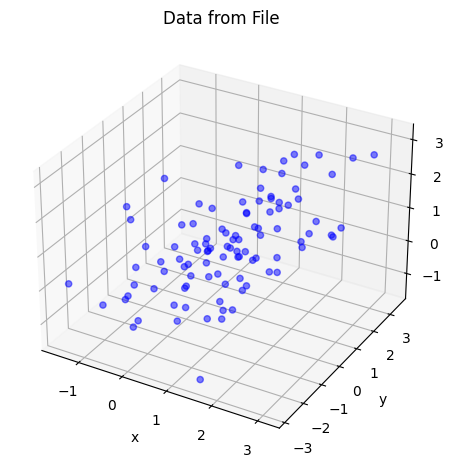

In [65]:

#Plot the samples of the MGD.csv file and the learned distribution
gd.plot_samples_and_distribution()
plt.show()

#This will display a figure with two subfigures: one showing the scatter plot of the samples from the MGD.csv file, and the other showing the learned multivariate Gaussian distribution and the sampled data. The number of dimensions of the learned distribution will depend on the number of columns in the MGD.csv file.

In [ ]:
import abc
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

class ContinuousDistribution(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def import_data(self, file_path):
        pass

    @abc.abstractmethod
    def export_data(self, data, file_path):
        pass

    @abc.abstractmethod
    def compute_mean(self, data):
        pass

    @abc.abstractmethod
    def compute_standard_deviation(self, data):
        pass

    @abc.abstractmethod
    def visualize(self, data=None):
        pass

    @abc.abstractmethod
    def generate_samples(self, n_samples):
        pass


New Class named GassDistribution: Inherits from ConitnousDistribution.
In this implementation, GaussDistribution inherits from ContinuousDistribution and provides concrete implementations for all its abstract methods. The constructor takes an optional dim parameter, which sets the dimension of the multivariate distribution (default value is 1).

The import_data and export_data methods are left unimplemented in this example, as they are not specific to the Gaussian distribution and can be implemented differently for different types of distributions.

The compute_mean method calculates the mean of the data and updates the mean attribute of the Gaussian distribution. Similarly, the compute_standard_deviation method calculates the covariance matrix of the data and updates the covariance attribute of the Gaussian distribution.

The visualize method generates a random sample of data from the Gaussian distribution using the multivariate_normal.rvs function from the scipy.stats module. If the data parameter is not provided, it uses this random sample to visualize the distribution. Otherwise, it visualizes the provided data.

The generate_samples method generates a given number of random samples from the Gaussian distribution using the multivariate_normal.rvs function and returns them.

In [4]:
import abc
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
import pandas as pd

class ContinuousDistribution(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def import_data(self, file_path):
        pass
    
    @abc.abstractmethod
    def export_data(self, data, file_path):
        pass
    
    @abc.abstractmethod
    def compute_mean(self, data):
        pass
    
    @abc.abstractmethod
    def compute_standard_deviation(self, data):
        pass
    
    @abc.abstractmethod
    def visualize(self, data=None):
        pass
    
    @abc.abstractmethod
    def generate_samples(self, n_samples):
        pass

class GaussDistribution(ContinuousDistribution):
    def __init__(self, dim=1):
        self.dim = dim
        self.mean = np.zeros(dim)
        self.covariance = np.eye(dim)
        self.data = pd.DataFrame()
    
    def import_data(self, file_path):
        # implementation to import data from file
        self.data = pd.read_csv(file_path)
    
    def export_data(self, data, file_path):
        # implementation to export data to file
        df = pd.DataFrame(data)
        df.to_csv(file_path)
    
    def compute_mean(self, data):
        self.mean = np.mean(data, axis=0)
    
    def compute_standard_deviation(self, data):
        self.covariance = np.cov(data, rowvar=False)
    
    def visualize(self, data=None):
        if data is None:
            data = multivariate_normal.rvs(mean=self.mean, cov=self.covariance, size=1000)
        
        if self.dim == 1:
            plt.hist(data, density=True, alpha=0.5)
            x = np.linspace(self.mean - 3*np.sqrt(self.covariance), self.mean + 3*np.sqrt(self.covariance), 100)
            plt.plot(x, multivariate_normal.pdf(x, mean=self.mean, cov=self.covariance))
            plt.show()
            
        elif self.dim == 2:
            x, y = np.mgrid[self.mean[0]-3*np.sqrt(self.covariance[0,0]):self.mean[0]+3*np.sqrt(self.covariance[0,0]):.01,
                            self.mean[1]-3*np.sqrt(self.covariance[1,1]):self.mean[1]+3*np.sqrt(self.covariance[1,1]):.01]
            pos = np.empty(x.shape + (2,))
            pos[:, :, 0] = x
            pos[:, :, 1] = y
            rv = multivariate_normal(self.mean, self.covariance)
            fig, ax = plt.subplots()
            ax.contourf(x, y, rv.pdf(pos), cmap='Blues')
            ax.scatter(data[:,0], data[:,1], alpha=0.5)
            plt.show()
            
        elif self.dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            x, y, z = np.mgrid[self.mean[0]-3*np.sqrt(self.covariance[0,0]):self.mean[0]+3*np.sqrt(self.covariance[0,0]):.1,
                               self.mean[1]-3*np.sqrt(self.covariance[1,1]):self.mean[1]+3*np.sqrt(self.covariance[1,1]):.1,
                               self.mean[2]-3*np.sqrt(self.covariance[2,2]):self.mean[2]+3*np.sqrt(self.covariance[2,2]):.1]
        
    def generate_samples(self, n_samples):
        return multivariate_normal.rvs(mean=self.mean, cov=self.covariance, size=n_samples)

In [12]:
gd = GaussDistribution(dim=3)

In [13]:
gd.import_data('MGD.csv')
data = gd.data

In [ ]:
gd.export_data(data, 'out.csv')

In [22]:
gd.compute_mean(data)
print(gd.mean)

x    0.984026
y    0.008833
z    0.860115
dtype: float64


In [23]:
gd.compute_standard_deviation(data)
print(gd.covariance)

[[0.95707677 0.65248406 0.5632227 ]
 [0.65248406 1.42016015 0.75382979]
 [0.5632227  0.75382979 1.25559884]]


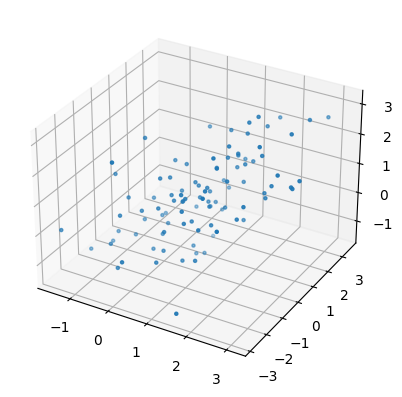

In [66]:
gd.visualize(gd.data)

In [20]:
gd.generate_samples(10)

array([[ 1.11689722, -1.29678225,  0.62134096],
       [ 0.69858365,  1.20867828,  1.64416471],
       [ 0.13820275,  0.41906985,  0.87366751],
       [ 1.89379146,  1.33516553,  2.30990182],
       [ 2.24696832,  1.07315982,  2.0897559 ],
       [ 1.87109172,  0.4600288 ,  0.50459608],
       [-1.75938041, -2.24931349,  0.46168468],
       [ 0.15945554,  1.14083262,  1.89765993],
       [ 0.88662562, -0.51708653,  0.30070803],
       [ 1.11015606, -1.72427079, -0.67130656]])

In [21]:
gd.data

,x,y,z
0,1.837130,2.830783,2.489846
1,1.847345,0.540222,0.105313
2,-0.769538,-0.960047,-0.548962
3,0.027689,-0.138528,-0.095424
4,2.195373,-0.348212,1.115202
...,...,...,...
95,1.552589,-2.819266,-1.448327
96,1.600879,1.133391,1.018098
97,3.044786,0.552303,1.601142
98,1.463682,0.533689,2.428866
